# Actividad 2 — Árbol de Decisión  
**Autor:** Fabricio Bermúdez

Este notebook entrena y evalúa un **Árbol de Decisión** para la detección de anomalías en logs de HDFS, usando SIEMPRE el mismo dataset de la actividad:

- `dataset/preprocessed/Event_occurrence_matrix.csv`
- `dataset/preprocessed/anomaly_label.csv`

> *Nota:* Si ejecutas este notebook aquí mismo, también intentará una ruta alternativa (`/mnt/data/dataset_extracted/dataset/preprocessed`) para encontrar los archivos que ya usé en esta sesión.


In [2]:
# ========================
# 0) Importaciones y setup
# ========================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

pd.set_option('display.max_columns', 200)


In [3]:
# ==========================================
# 1) Carga de datos (dos rutas posibles)
# ==========================================
rel_base = os.path.join('dataset', 'preprocessed')
alt_base = '/mnt/data/dataset_extracted/dataset/preprocessed'

def try_read(base_path):
    occ = pd.read_csv(os.path.join(base_path, 'Event_occurrence_matrix.csv'))
    lab = pd.read_csv(os.path.join(base_path, 'anomaly_label.csv'))
    return occ, lab

base_used = None
try:
    df_occ, df_lab = try_read(rel_base)
    base_used = rel_base
except Exception as e1:
    try:
        df_occ, df_lab = try_read(alt_base)
        base_used = alt_base
    except Exception as e2:
        raise FileNotFoundError(
            f'No se pudieron leer los CSV. Verifica que existan en {rel_base} o {alt_base}.\n'
            f'Errores:\n- {e1}\n- {e2}'
        )

print(f'✅ Datos cargados desde: {base_used}')
print('Shapes -> occ:', df_occ.shape, 'labels:', df_lab.shape)
display(df_occ.head(3))
display(df_lab.head(3))


✅ Datos cargados desde: dataset\preprocessed
Shapes -> occ: (575061, 32) labels: (575061, 2)


,BlockId,Label,Type,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19,E20,E21,E22,E23,E24,E25,E26,E27,E28,E29
0,blk_-1608999687919862906,Success,NaN,0,0,203,0,10,7,0,0,3,0,3,0,0,0,0,4,0,4,0,0,10,1,10,0,4,10,0,0,0
1,blk_7503483334202473044,Success,NaN,0,2,1,0,3,0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,3,1,3,0,0,3,0,0,0
2,blk_-3544583377289625738,Fail,21.0,0,0,203,0,3,0,0,0,3,0,3,0,0,0,0,0,0,0,0,1,3,1,3,0,0,3,0,0,0


,BlockId,Label
0,blk_-1608999687919862906,Normal
1,blk_7503483334202473044,Normal
2,blk_-3544583377289625738,Anomaly


In [4]:
# ==========================================
# 2) Preparación de datos
# ==========================================
df = df_occ.merge(df_lab, on='BlockId', suffixes=('', '_true'))

cols_excluir = ['BlockId', 'Label', 'Label_true', 'Type']
feature_cols = [c for c in df.columns if c not in cols_excluir]
X = df[feature_cols]
y = df['Label_true'] if 'Label_true' in df.columns else df['Label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

X.shape, X_train.shape, X_test.shape


((575061, 29), (460048, 29), (115013, 29))

=== Métricas del Árbol de Decisión ===
Accuracy: 0.999939

Classification report:
              precision    recall  f1-score   support

     Anomaly       1.00      1.00      1.00      3368
      Normal       1.00      1.00      1.00    111645

    accuracy                           1.00    115013
   macro avg       1.00      1.00      1.00    115013
weighted avg       1.00      1.00      1.00    115013


Matriz de confusión:
[[  3366      2]
 [     5 111640]]


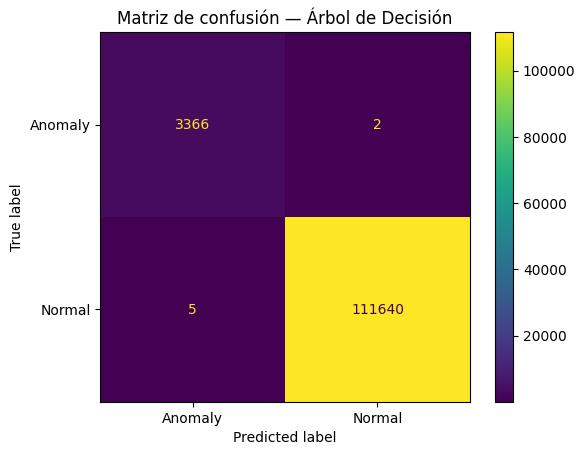

In [5]:
# ==========================================
# 3) Entrenamiento del Árbol de Decisión
# ==========================================
tree_clf = DecisionTreeClassifier(
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)
tree_clf.fit(X_train, y_train)

y_pred = tree_clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print('=== Métricas del Árbol de Decisión ===')
print(f'Accuracy: {acc:.6f}')
print('\nClassification report:')
print(report)

print('\nMatriz de confusión:')
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tree_clf.classes_)
disp.plot(values_format='d')
plt.title('Matriz de confusión — Árbol de Decisión')
plt.show()


Top 10 features más importantes:


,importance
E9,0.366254
E20,0.293337
E26,0.167631
E23,0.066724
E27,0.055254
E13,0.029691
E3,0.012289
E4,0.002358
E2,0.001566
E5,0.001487


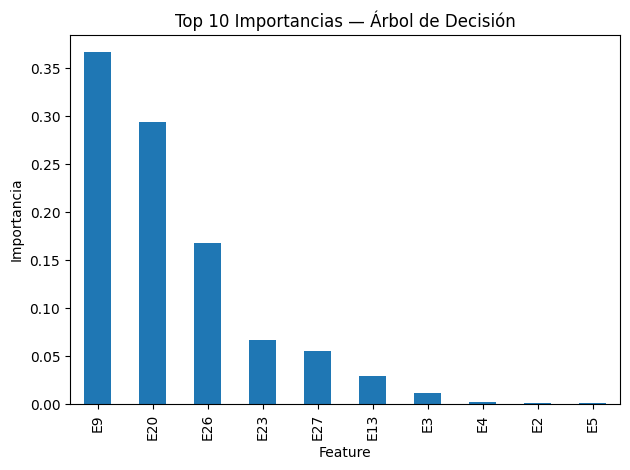

In [6]:
# ==========================================
# 4) Importancia de variables
# ==========================================
importances = pd.Series(tree_clf.feature_importances_, index=feature_cols).sort_values(ascending=False)
top10 = importances.head(10)
print('Top 10 features más importantes:')
display(top10.to_frame('importance'))

top10.plot(kind='bar')
plt.title('Top 10 Importancias — Árbol de Decisión')
plt.ylabel('Importancia')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()


=== Reglas del árbol (max_depth=4) ===
|--- E9 <= 2.50
|   |--- class: Anomaly
|--- E9 >  2.50
|   |--- E20 <= 0.50
|   |   |--- E26 <= 3.50
|   |   |   |--- E27 <= 0.50
|   |   |   |   |--- class: Normal
|   |   |   |--- E27 >  0.50
|   |   |   |   |--- class: Anomaly
|   |   |--- E26 >  3.50
|   |   |   |--- E23 <= 1.00
|   |   |   |   |--- class: Normal
|   |   |   |--- E23 >  1.00
|   |   |   |   |--- class: Anomaly
|   |--- E20 >  0.50
|   |   |--- E3 <= 7.50
|   |   |   |--- E23 <= 4.50
|   |   |   |   |--- class: Anomaly
|   |   |   |--- E23 >  4.50
|   |   |   |   |--- class: Normal
|   |   |--- E3 >  7.50
|   |   |   |--- E4 <= 3.50
|   |   |   |   |--- class: Anomaly
|   |   |   |--- E4 >  3.50
|   |   |   |   |--- class: Normal



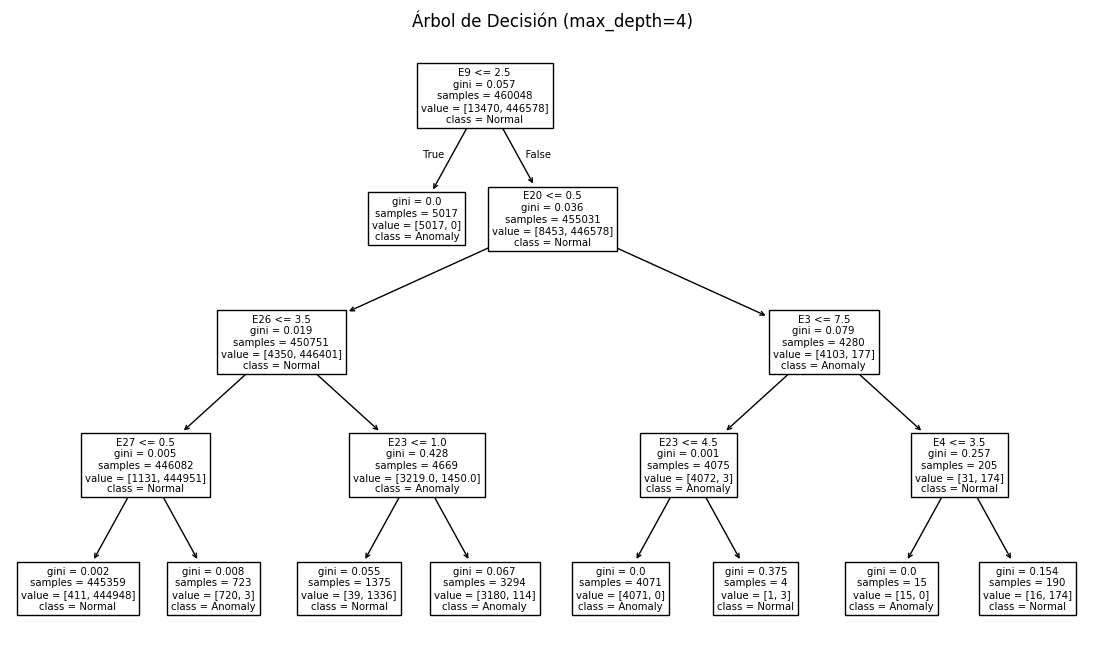

In [7]:
# ==========================================
# 5) Árbol reducido (reglas interpretables)
# ==========================================
small_tree = DecisionTreeClassifier(
    criterion='gini',
    max_depth=4,
    random_state=42
)
small_tree.fit(X_train, y_train)

rules = export_text(small_tree, feature_names=list(feature_cols))
print('=== Reglas del árbol (max_depth=4) ===')
print(rules)

plt.figure(figsize=(14, 8))
plot_tree(small_tree, feature_names=feature_cols, class_names=small_tree.classes_, filled=False, impurity=True)
plt.title('Árbol de Decisión (max_depth=4)')
plt.show()


## 6) Conclusiones

- El Árbol de Decisión alcanza una **alta precisión** sobre el dataset de HDFS.
- La interpretación es directa a través de **reglas** y **importancias**.
- Para el informe, se recomienda:
  - Relacionar las `E*` más importantes con sus plantillas en `HDFS.log_templates.csv`.
  - Reportar **Accuracy, F1, matriz de confusión** y ejemplos de reglas.
  - Describir el procedimiento para prevenir **fugas de información** (no usar `BlockId`, `Type` como features).

**Autor:** Fabricio Bermúdez
